In [21]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from numpy import mean
from numpy import std
from sklearn.datasets import make_regression
from sklearn.model_selection import RepeatedKFold
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import math



%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

from keras.models import Sequential
from keras.layers import Dense, LSTM, TimeDistributed
from keras.optimizers import RMSprop
from keras.wrappers.scikit_learn import KerasRegressor
from keras import optimizers

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

df = pd.read_csv('../data/data2.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2112 entries, 0 to 2111
Data columns (total 13 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ID         2112 non-null   int64  
 1   Substrate  2112 non-null   object 
 2   Ceramic    2112 non-null   object 
 3   Thickness  2112 non-null   float64
 4   Lsub       2112 non-null   float64
 5   asub       2112 non-null   float64
 6   bsub       2112 non-null   float64
 7   Lcer       2112 non-null   float64
 8   acer       2112 non-null   float64
 9   bcer       2112 non-null   float64
 10  L          2112 non-null   float64
 11  a          2112 non-null   float64
 12  b          2112 non-null   float64
dtypes: float64(10), int64(1), object(2)
memory usage: 214.6+ KB


In [79]:
np.set_printoptions(suppress=True)

In [80]:
# Separate Target Variable and Predictor Variables
TargetVariable=['L', 'a', 'b']
Predictors=['Thickness','Lsub', 'asub','bsub', 'Lcer', 'acer', 'bcer']
 
X=df[Predictors].values
y=df[TargetVariable].values
 
### Sandardization of data ###
from sklearn.preprocessing import StandardScaler
PredictorScaler=StandardScaler()
TargetVarScaler=StandardScaler()
 
# Storing the fit object for later reference
PredictorScalerFit=PredictorScaler.fit(X)
TargetVarScalerFit=TargetVarScaler.fit(y)
 
# Generating the standardized values of X and y
X=PredictorScalerFit.transform(X)
y=TargetVarScalerFit.transform(y)
 
# Split the data into training and testing set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
 
# Quick sanity check with the shapes of Training and testing datasets
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(1478, 7)
(1478, 3)
(634, 7)
(634, 3)


In [111]:
# importing the libraries
from keras.models import Sequential
from keras.layers import Dense
 
# create ANN model
model = Sequential()
 
# Defining the Input layer and FIRST hidden layer, both are same!
model.add(Dense(units=2, input_dim=7, kernel_initializer='normal', activation='relu'))
 
# Defining the Second layer of the model
# after the first layer we don't have to specify input_dim as keras configure it automatically
model.add(Dense(units=5, kernel_initializer='normal', activation='relu'))
 
# There are 3 output neurons since we will be predicting a single number
model.add(Dense(3, kernel_initializer='normal', activation='linear'))
 
# Compiling the model
model.compile(loss='mae', optimizer='adam')
 
# Fitting the ANN to the Training set
model.fit(X_train, y_train ,batch_size = 20, epochs = 50, verbose=0)

In [112]:
print(f'model score on training data: {model.evaluate(X_train, y_train, verbose = 0)}')
print(f'model score on testing data: {model.evaluate(X_test, y_test, verbose = 0)}')

model score on training data: 0.27581822872161865
model score on testing data: 0.2624717950820923


In [113]:
def FindLayerNodesLinear(n_layers, first_layer_nodes, last_layer_nodes):
    layers = []
    
    nodes_increment = (last_layer_nodes - first_layer_nodes)/ (n_layers-1)
    nodes = first_layer_nodes
    for i in range(1, n_layers+1):
        layers.append(math.ceil(nodes))
        nodes = nodes + nodes_increment
    
    return layers

In [114]:
def createmodel(n_layers, first_layer_nodes, last_layer_nodes, activation_func, loss_func):
    model = Sequential()
    n_nodes = FindLayerNodesLinear(n_layers, first_layer_nodes, last_layer_nodes)
    for i in range(1, n_layers):
        if i==1:
            model.add(Dense(first_layer_nodes, input_dim=X_train.shape[1], activation=activation_func))
        else:
            model.add(Dense(n_nodes[i-1], activation=activation_func))
            
    #Finally, the output layer should have a single node in binary classification
    model.add(Dense(3, activation='linear'))
    model.compile(optimizer='adam', loss=loss_func, metrics = ["accuracy"]) #note: metrics could also be 'mse'
    
    return model

##Wrap model into scikit-learn
model =  KerasRegressor(build_fn=createmodel, verbose = False)  

In [119]:
activation_funcs = ['relu']#['sigmoid', 'relu', 'tanh'] 
loss_funcs = ['mae'] #['mean_squared_error','hinge','mae']
param_grid = dict(n_layers=[1,2], first_layer_nodes = [20, 10, 5, 3], last_layer_nodes = [20, 10, 5, 3],  activation_func = activation_funcs, loss_func = loss_funcs, batch_size = [20, 50, 100], epochs = [20, 50, 100])
grid = GridSearchCV(estimator = model, param_grid = param_grid, cv=10, n_jobs=-1, verbose=1, scoring = "neg_mean_absolute_error")

In [120]:
%%time
grid.fit(X_train,y_train)

Fitting 10 folds for each of 288 candidates, totalling 2880 fits


2022-09-14 13:52:36.459201: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-14 13:52:36.459202: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-14 13:52:36.459201: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the ap

CPU times: user 14.5 s, sys: 1.85 s, total: 16.4 s
Wall time: 10min 13s


GridSearchCV(cv=10,
             estimator=<keras.wrappers.scikit_learn.KerasRegressor object at 0x7f7b7bdb4f10>,
             n_jobs=-1,
             param_grid={'activation_func': ['relu'],
                         'batch_size': [20, 50, 100], 'epochs': [20, 50, 100],
                         'first_layer_nodes': [20, 10, 5, 3],
                         'last_layer_nodes': [20, 10, 5, 3],
                         'loss_func': ['mae'], 'n_layers': [1, 2]},
             scoring='neg_mean_absolute_error', verbose=1)

In [121]:
print(grid.best_score_)
print(grid.best_params_)

-0.06887046425374195
{'activation_func': 'relu', 'batch_size': 20, 'epochs': 100, 'first_layer_nodes': 20, 'last_layer_nodes': 3, 'loss_func': 'mae', 'n_layers': 2}


In [122]:
score_df = pd.DataFrame(grid.cv_results_)
score_df.sort_values(by='rank_test_score').head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_activation_func,param_batch_size,param_epochs,param_first_layer_nodes,param_last_layer_nodes,param_loss_func,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
71,18.338068,1.291564,0.288546,0.063744,relu,20,100,20,3,mae,...,-0.081346,-0.058527,-0.065151,-0.066848,-0.065472,-0.080645,-0.058184,-0.068870,0.010163,1
69,18.468438,1.285282,0.277922,0.060312,relu,20,100,20,5,mae,...,-0.076391,-0.066598,-0.061889,-0.065546,-0.075398,-0.069179,-0.069918,-0.069070,0.006255,2
65,19.090812,1.007424,0.288944,0.057838,relu,20,100,20,20,mae,...,-0.081819,-0.067059,-0.069016,-0.058073,-0.067312,-0.075713,-0.067059,-0.070657,0.007784,3
67,18.588264,0.584273,0.332480,0.023294,relu,20,100,20,10,mae,...,-0.085561,-0.073898,-0.081190,-0.055653,-0.086990,-0.085374,-0.063882,-0.075464,0.009616,4
161,7.790352,0.210971,0.290733,0.043715,relu,50,100,20,20,mae,...,-0.086419,-0.068597,-0.088222,-0.065577,-0.098715,-0.074164,-0.106534,-0.081442,0.012919,5


In [123]:
# Running the best parameters for the NN

# create ANN model
model = Sequential()
 
# Defining the Input layer and FIRST hidden layer, both are same!
model.add(Dense(units=20, input_dim=7, kernel_initializer='normal', activation='relu'))
 
# Defining the Second layer of the model
# after the first layer we don't have to specify input_dim as keras configure it automatically
model.add(Dense(units=3, kernel_initializer='normal', activation='relu'))
 
# There are 3 output neurons since we will be predicting a single number
model.add(Dense(3, kernel_initializer='normal', activation='linear'))
 
# Compiling the model
model.compile(loss='mae', optimizer='adam')
 
# Fitting the ANN to the Training set
model.fit(X_train, y_train ,batch_size = 20, epochs = 100, verbose=0)

In [124]:
# Generating Predictions on testing data
Predictions=model.predict(X_test)
 
# Scaling the predicted Price data back to original price scale
Predictions=TargetVarScalerFit.inverse_transform(Predictions)
 
# Scaling the y_test Price data back to original price scale
y_test_orig=TargetVarScalerFit.inverse_transform(y_test)
 
# Scaling the test data back to original scale
Test_Data=PredictorScalerFit.inverse_transform(X_test)

TestingData=pd.DataFrame(data=Test_Data, columns=Predictors)
y_orig = pd.DataFrame(data=y_test_orig, columns=TargetVariable)
y_pred = pd.DataFrame(data=Predictions, columns=TargetVariable)

20/20 [==============================] - 0s 658us/step


In [132]:
# Computing the absolute percent error
APE=100*(abs(y_orig['L']-y_pred['L'])/y_orig['L'])
print('The Accuracy of L using the ANN model is:', 100-np.mean(APE),"(std=",np.std(APE),")")

# Computing the absolute percent error
APE=100*(abs(y_orig['a']-y_pred['a'])/y_orig['a'])
print('The Accuracy of a using the ANN model is:', 100-np.mean(APE),"(std=",np.std(APE),")")

# Computing the absolute percent error
APE=100*(abs(y_orig['b']-y_pred['a'])/y_orig['b'])
print('The Accuracy of b using the ANN model is:', 100-np.mean(APE),"(std=",np.std(APE),")")


The Accuracy of L using the ANN model is: 96.06984886069259 (std= 19.177909752365608 )
The Accuracy of a using the ANN model is: -inf (std= nan )
The Accuracy of b using the ANN model is: 36.93746423313416 (std= 248.06612471834055 )


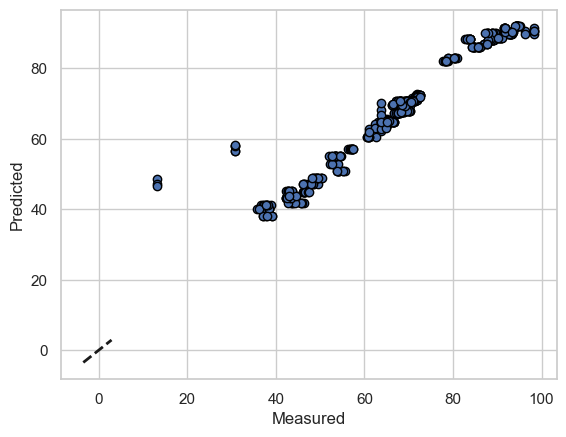

In [136]:
fig, ax = plt.subplots()
ax.scatter(y_orig['L'], y_pred['L'], edgecolors=(0, 0, 0))
ax.plot([y.min(), y.max()], [y.min(), y.max()], "k--", lw=2)
ax.set_xlabel("Measured")
ax.set_ylabel("Predicted")
plt.show()

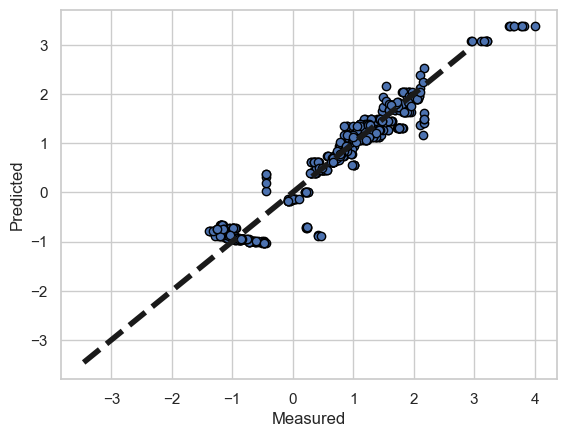

In [134]:
fig, ax = plt.subplots()
ax.scatter(y_orig['a'], y_pred['a'], edgecolors=(0, 0, 0))
ax.plot([y.min(), y.max()], [y.min(), y.max()], "k--", lw=4)
ax.set_xlabel("Measured")
ax.set_ylabel("Predicted")
plt.show()

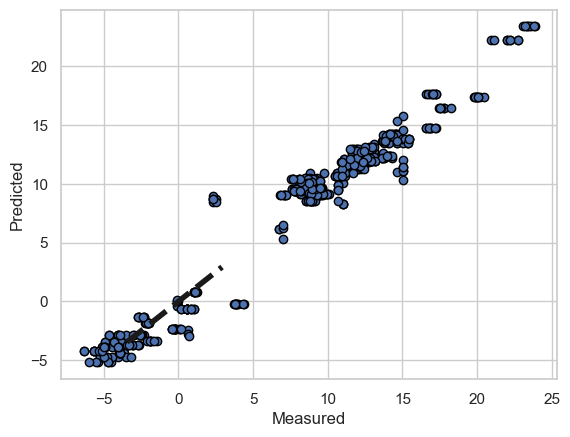

In [137]:
fig, ax = plt.subplots()
ax.scatter(y_orig['b'], y_pred['b'], edgecolors=(0, 0, 0))
ax.plot([y.min(), y.max()], [y.min(), y.max()], "k--", lw=4)
ax.set_xlabel("Measured")
ax.set_ylabel("Predicted")
plt.show()

In [138]:
# Define regression model in Keras
def regression_model():
    # Define model
    model = Sequential()
    model.add(Dense(units=20, input_dim=7, kernel_initializer='normal', activation='relu'))
    model.add(Dense(units=3, kernel_initializer='normal', activation='relu'))
    model.add(Dense(3, kernel_initializer='normal', activation='linear'))
    
    # Compile model
    model.compile(loss='mae', optimizer='adam',metrics=['accuracy'])
    
    return model

# Use KerasRegressor wrapper (from Keras to sklearn)
# The packages we use are meant to be run with sklearn models
estimator = KerasRegressor(build_fn=regression_model, validation_split = 0.2, epochs=100, batch_size = 20, verbose=0)
history = estimator.fit(X_train, y_train)

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


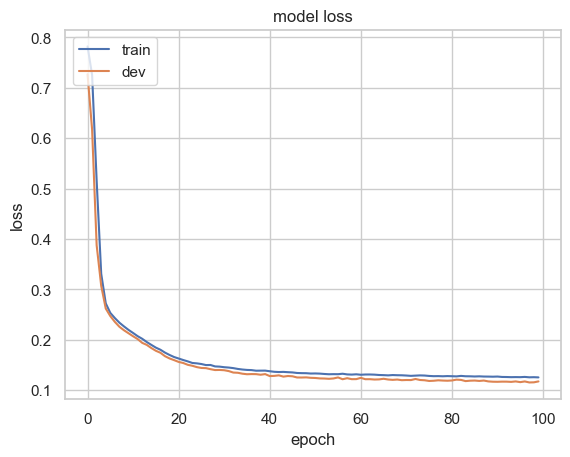

In [139]:
# summarize history loss
print(history.history.keys())
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper left')
plt.show()

In [148]:
from keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(estimator, random_state=1).fit(X_train,y_train)
eli5.show_weights(perm, feature_names = Predictors)

Weight,Feature
0.5816 ± 0.0218,bsub
0.3295 ± 0.0091,Lsub
0.2864 ± 0.0263,asub
0.2378 ± 0.0107,Thickness
0.0813 ± 0.0047,acer
0.0587 ± 0.0036,bcer
0.0411 ± 0.0015,Lcer


In [152]:
#get model
def get_model(n_inputs, n_outputs):
    model = Sequential()
    model.add(Dense(20, input_dim=n_inputs, kernel_initializer='he_uniform', activation='relu'))
    model.add(Dense(3, activation='relu'))
    model.add(Dense(n_outputs, activation = 'linear'))
    model.compile(loss='mae', optimizer='adam')
    return model

In [153]:
# evaluate a model using repeated k-fold cross-validation
def evaluate_model(X, y):
    results = []
    n_inputs, n_outputs = X.shape[1], y.shape[1]
    # define evaluation procedure
    cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=42)
    # enumerate folds
    for train_ix, test_ix in cv.split(X):
        # prepare data
        X_train, X_test = X[train_ix], X[test_ix]
        y_train, y_test = y[train_ix], y[test_ix]
        # define model
        model = get_model(n_inputs, n_outputs)
        # fit model
        model.fit(X_train, y_train, verbose=0, epochs=100, batch_size = 20)
        # evaluate model on test set
        mae = model.evaluate(X_test, y_test, verbose=0)
        # store result
        print('>%.3f' % mae)
        results.append(mae)
    return results

In [154]:
# evaluate model
results = evaluate_model(X, y)
# summarize performance
print('MAE: %.3f (%.3f)' % (mean(results), std(results)))

>0.123
>0.108
>0.097
>0.100
>0.150
>0.234
>0.117
>0.136
>0.153
>0.167
>0.122
>0.145
>0.171
>0.139
>0.186
>0.159
>0.368
>0.170
>0.178
>0.107
>0.145
>0.115
>0.223
>0.123
>0.097
>0.296
>0.115
>0.126
>0.123
>0.103
MAE: 0.153 (0.059)


In [65]:
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)

X_test_scaled = scaler.transform(X_test)

pred = pd.DataFrame(model.predict(X_test_scaled), columns=['Lpred','apred','bpred'])

14/14 [==============================] - 0s 679us/step


In [184]:
import gradio as gr

def greet(Thickness, Lsub, asub, bsub, Lcer, acer, bcer):
    list = [Thickness, Lsub, asub, bsub, Lcer, acer, bcer]
    df2 = pd.DataFrame(list).T
    scaler.fit(X_train)
    df2 = scaler.transform(df2)
    output = model.predict(df2)
    output = TargetVarScalerFit.inverse_transform(output)

    Lf = pd.DataFrame(output, columns = ['L', 'a', 'b'])._get_value(0, 'L')
    af = pd.DataFrame(output, columns = ['L', 'a', 'b'])._get_value(0, 'a')
    bf = pd.DataFrame(output, columns = ['L', 'a', 'b'])._get_value(0, 'b')
    
    Lf = np.clip(Lf, np.min([Lcer,Lsub]), np.max([Lcer,Lsub]))
    af = np.clip(af, np.min([acer,asub]), np.max([acer,asub]))
    bf = np.clip(bf, np.min([bcer,bsub]), np.max([bcer,bsub]))
    
    return Lf, af, bf

demo = gr.Interface(fn=greet, inputs=[gr.Slider(0, 5, 0.1),
                                      gr.Slider(0, 100, 1),
                                      gr.Slider(-10, 10, 0.2),
                                      gr.Slider(-20, 20, 0.2),
                                      gr.Slider(0, 100, 1),
                                      gr.Slider(-10, 10, 0.2),
                                      gr.Slider(-20, 20, 0.2)], outputs=["number","number", "number"])

In [185]:
demo.launch()

Running on local URL:  http://127.0.0.1:7861

To create a public link, set `share=True` in `launch()`.


(<gradio.routes.App at 0x7f7b8ccc8d90>, 'http://127.0.0.1:7861/', None)

1/1 [==============================] - 0s 18ms/step
